# Generar Variables Climatológicas

Notebook para generar las variables climatológicas.

**Dependencias:**
- [jupyter](https://jupyter.org/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://numpy.org/)
- [pandas](https://pandas.pydata.org/)
- [seaborn](https://seaborn.pydata.org/)
- [xgboost](https://xgboost.readthedocs.io/en/stable/)

In [1]:
import datetime
import math as m
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

## Constantes

### Directorio de Datos

In [3]:
DATA_DIR_NAME = 'data'
PROJECT_DIR = os.path.abspath(os.pardir)
DATA_DIR = os.path.join(PROJECT_DIR, DATA_DIR_NAME)

### Lista de Departamentos

In [4]:
DEPARTS = [
    'ANTIOQUIA', 
    'ARAUCA', 
    'ATLANTICO', 
    'BOGOTA', 
    'BOLIVAR', 
    'BOYACA', 
    'CALDAS', 
    'CAQUETA', 
    'CASANARE', 
    'CAUCA', 
    'CESAR', 
    'CHOCO', 
    'CORDOBA', 
    'CUNDINAMARCA', 
    'GUAVIARE', 
    'HUILA', 
    'LA GUAJIRA', 
    'MAGDALENA', 
    'META', 
    'NARINO', 
    'NORTE DE SANTANDER', 
    'PUTUMAYO', 
    'QUINDIO', 
    'RISARALDA', 
    'SANTANDER', 
    'SUCRE', 
    'TOLIMA', 
    'VALLE DEL CAUCA'
]

### Mapeo Departamento - Región

| REGION       | DEPARTAMENTO            | | | REGION       | DEPARTAMENTO                 |
|:-------------|:------------------------|-|-|:-------------|:-----------------------------|
| Antioquia    | ANTIOQUIA               | | | Drummond     | CESAR                        |
| Arauca       | ARAUCA                  | | | Emec         | NARINO                       |
| Atlantico    | ATLANTICO               | | | GCM          | LA GUAJIRA, CESAR, MAGDALENA |
| BajoPutumayo | PUTUMAYO                | | | Guaviare     | GUAVIARE                     |
| Bolivar      | BOLIVAR                 | | | Huila        | HUILA                        |
| Boyaca       | BOYACA                  | | | Intercor     | LA GUAJIRA                   |
| Caldas       | CALDAS                  | | | Meta         | META                         |
| Cali         | VALLE DEL CAUCA         | | | Narino       | NARINO                       |
| Caqueta      | CAQUETA                 | | | NorSantander | NORTE DE SANTANDER           |
| Cartago      | VALLE DEL CAUCA         | | | Oxy          | CAQUETA                      |
| Casanare     | CASANARE                | | | Pereira      | RISARALDA                    |
| Cauca        | CAUCA                   | | | Planeta      | CORDOBA                      |
| Celsia       | VALLE DEL CAUCA, TOLIMA | | | Putumayo     | PUTUMAYO                     |
| Cerromatoso  | CORDOBA                 | | | Quindio      | QUINDIO                      |
| Choco        | CHOCO                   | | | Rubiales     | META                         |
| CiraInfanta  | SANTANDER               | | | Santander    | SANTANDER                    |
| Codensa      | BOGOTA                  | | | Tolima       | TOLIMA                       |
| CordobaSucre | CORDOBA, SUCRE          | | | TubosCaribe  | BOLIVAR                      |
| Cundinamarca | CUNDINAMARCA            | | | Tulua        | VALLE DEL CAUCA              |

In [5]:
DEPARTS_REGIONS = {
    'Antioquia': ['ANTIOQUIA'],
    'Arauca': ['ARAUCA'],
    'Atlantico': ['ATLANTICO'],
    'BajoPutumayo': ['PUTUMAYO'],
    'Bolivar': ['BOLIVAR'],
    'Boyaca': ['BOYACA'],
    'Caldas': ['CALDAS'],
    'Cali': ['VALLE DEL CAUCA'],
    'Caqueta': ['CAQUETA'],
    'Cartago': ['VALLE DEL CAUCA'],
    'Casanare': ['CASANARE'],
    'Cauca': ['CAUCA'],
    'Celsia': ['VALLE DEL CAUCA', 'TOLIMA'],
    'Cerromatoso': ['CORDOBA'],
    'Choco': ['CHOCO'],
    'CiraInfanta': ['SANTANDER'],
    'Codensa': ['BOGOTA'],
    'CordobaSucre': ['CORDOBA', 'SUCRE'],
    'Cundinamarca': ['CUNDINAMARCA'],
    'Drummond': ['CESAR'],
    'Emec': ['NARINO'],
    'GCM': ['LA GUAJIRA', 'CESAR', 'MAGDALENA'],
    'Guaviare': ['GUAVIARE'],
    'Huila': ['HUILA'],
    'Intercor': ['LA GUAJIRA'],
    'Meta': ['META'],
    'Narino': ['NARINO'],
    'NorSantander': ['NORTE DE SANTANDER'],
    'Oxy': ['CAQUETA'],
    'Pereira': ['RISARALDA'],
    'Planeta': ['CORDOBA'],
    'Putumayo': ['PUTUMAYO'],
    'Quindio': ['QUINDIO'],
    'Rubiales': ['META'],
    'Santander': ['SANTANDER'],
    'Tolima': ['TOLIMA'],
    'TubosCaribe': ['BOLIVAR'],
    'Tulua': ['VALLE DEL CAUCA'],
}

### Lista de Regiones

In [6]:
REGIONS = list(DEPARTS_REGIONS.keys())

## Análisis de Correlación

Se usan las variables climatológicas y la demanda del _**2017-01-01**_ al _**2020-09-30**_:
- PRESION
- HUMEDAD
- PRECIPITACION
- TEMPERATURA_HUMEDA
- TEMPERATURA_SECA
- HUMEDAD_RELATIVA_CALCULADA
- SENSACION_TERMICA_CALIENTE
- SENSACION_TERMICA_IDEAM
- DEMANDA

![Análisis de Correlación](../images/correlation_analysis.png)

In [9]:
columns = ['PRESION', 'HUMEDAD', 'PRECIPITACION', 'TEMPERATURA_HUMEDA', 'TEMPERATURA_SECA', 
           'HUMEDAD_RELATIVA_CALCULADA', 'SENSACION_TERMICA_CALIENTE', 'SENSACION_TERMICA_IDEAM', 'DEMANDA']

df = pd.read_csv(os.path.join(DATA_DIR, 'others', 'complete_dataset_type_2.csv'), 
                 usecols=columns)

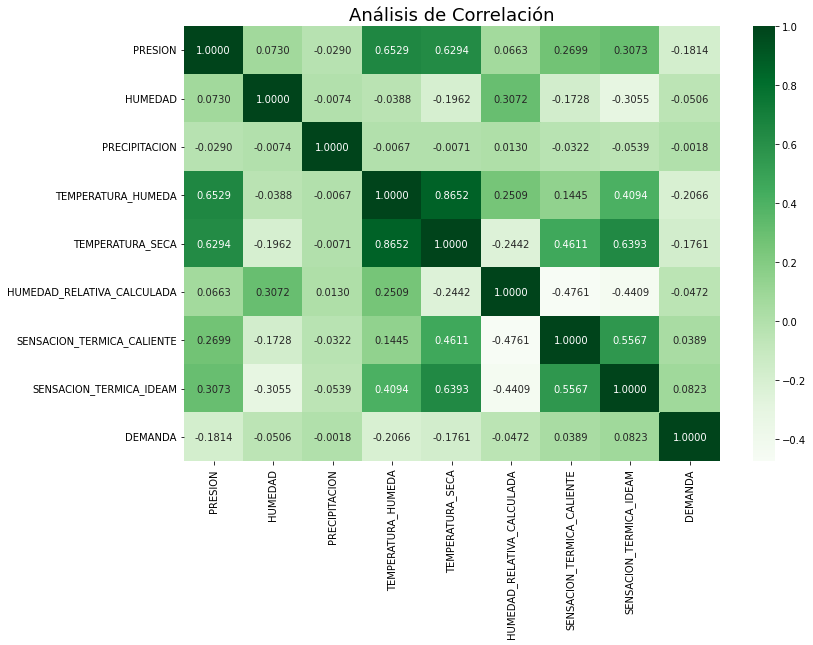

In [10]:
_ = plt.figure()
_ = sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Greens', xticklabels=columns, yticklabels=columns)
_ = plt.title('Análisis de Correlación', size=18)

## Creación del Árbol de Directorios

- \< *root_dir* \>
  - input
    - dry_temperature
      - *dpto_1*
        - \<*name*\>.csv
      - ...
      - *dpto_n*
        - \<*name*\>.csv
    - humid_temperature
      - *dpto_1*
        - \<*name*\>.csv
      - ...
      - *dpto_n*
        - \<*name*\>.csv
    - humidity
      - \<*name*\>.csv
    - precipitation
      - \<*name*\>.csv
    - pressure
      - \<*name*\>.csv
  - output
    - final
      - **dataset_clima.csv**
    - regions
      - *region_1*
        - dry_temperature.csv
        - humid_temperature.csv
        - humidity.csv
        - precipitation.csv
        - pressure.csv
      - ...
      - *region_m*
        - dry_temperature.csv
        - humid_temperature.csv
        - humidity.csv
        - precipitation.csv
        - pressure.csv

In [8]:
def generate_directory_tree(root_dir, input_=True, output_=True):
    if input_:
        for depart in DEPARTS:
            os.makedirs(os.path.join(root_dir, 'input', 'dry_temperature', depart), exist_ok=True)
            os.makedirs(os.path.join(root_dir, 'input', 'humid_temperature', depart), exist_ok=True)
        
        os.makedirs(os.path.join(root_dir, 'input', 'humidity'), exist_ok=True)
        os.makedirs(os.path.join(root_dir, 'input', 'precipitation'), exist_ok=True)
        os.makedirs(os.path.join(root_dir, 'input', 'pressure'), exist_ok=True)
    
    if output_:
        for region in REGIONS:
            os.makedirs(os.path.join(root_dir, 'output', 'regions', region), exist_ok=True)
        
        os.makedirs(os.path.join(root_dir, 'output', 'final'), exist_ok=True)

In [7]:
def generate_directory_tree(root_dir, input_=True, output_=True):
    if input_:
        os.makedirs(os.path.join(root_dir, 'input', 'humidity'), exist_ok=True)
        os.makedirs(os.path.join(root_dir, 'input', 'precipitation'), exist_ok=True)
        os.makedirs(os.path.join(root_dir, 'input', 'pressure'), exist_ok=True)
        os.makedirs(os.path.join(root_dir, 'input', 'temperature'), exist_ok=True)
    
    if output_:
        for region in REGIONS:
            os.makedirs(os.path.join(root_dir, 'output', 'regions', region), exist_ok=True)
        
        os.makedirs(os.path.join(root_dir, 'output', 'final'), exist_ok=True)

In [8]:
generate_directory_tree(DATA_DIR)

## Funciones
- load_data
- merge_dataframes
- fix_values
- fix_departs
- fix_columns
- get_thermal_sensation
- evaluate
- xgboost_regression

### Funciones para Dataframes

In [ ]:
def load_data(data_path, date_column, date_format='%Y%m%d', sep=',', rename=None):
    df = pd.read_csv(data_path, sep=sep)
    if rename:
        df.rename(columns=remane, inplace=True)
    df[date_column] = pd.to_datetime(df[date_column], format=date_format, infer_datetime_format=True)
    return df

def merge_dataframes(df_1, df_2, on, how='outer'):
    df = pd.merge(df_1, df_2, how=how, on=on)
    return df

### Funciones de Ajuste

- **Ajuste Final de Columnas:**

| ANTES                      | DESPUES                    |
|:---------------------------|:---------------------------|
| Fecha                      | FECHA                      |
| Hora                       | HORA                       |
| Region                     | REGION                     |
| Presion                    | PRESION                    |
| Humedad                    | HUMEDAD                    |
| Precipitacion              | PRECIPITACION              |
| Temperatura Humeda         | TEMPERATURA_HUMEDA         |
| Temperatura Seca           | TEMPERATURA_SECA           |
| Humedad Relativa Calculada | HUMEDAD_RELATIVA_CALCULADA |
| Sensacion Termica Caliente | SENSACION_TERMICA_CALIENTE |
| Sensacion Termica IDEAM    | SENSACION_TERMICA_IDEAM    |

In [ ]:
def fix_values(df, column, le_value=None, ge_value=None):
    if le_value is not None:
        df.loc[df[column] < le_value, column] = le_value
        
    if ge_value is not None:
        df.loc[df[column] > ge_value, column] = ge_value

    return df

def fix_departs(df, column):
    rename_departs = {
        'ATLÁNTICO': 'ATLANTICO',
        'BOGOTA D.C.': 'BOGOTA',
        'BOLÍVAR': 'BOLIVAR',
        'BOYACÁ': 'BOYACA',
        'CHOCÓ': 'CHOCO',
        'CÓRDOBA': 'CORDOBA',
        'NARIÑO': 'NARINO',
        'QUINDÍO': 'QUINDIO'
    }
    
    df[column].replace(to_replace=rename_departs, inplace=True)
    
    return df

def fix_columns(df):
    rename_columns = {
        'Fecha': 'FECHA',
        'Hora': 'HORA',
        'Region': 'REGION',
        'Presion': 'PRESION',
        'Humedad': 'HUMEDAD',
        'Precipitacion': 'PRECIPITACION',
        'Temperatura Humeda': 'TEMPERATURA_HUMEDA',
        'Temperatura Seca': 'TEMPERATURA_SECA',
        'Humedad Relativa Calculada': 'HUMEDAD_RELATIVA_CALCULADA',
        'Sensacion Termica Caliente': 'SENSACION_TERMICA_CALIENTE',
        'Sensacion Termica IDEAM': 'SENSACION_TERMICA_IDEAM'
    }
    
    df.rename(columns=rename_columns, inplace=True)
    
    column_names = [
        'FECHA',
        'HORA',
        'REGION',
        'PRESION',
        'HUMEDAD',
        'PRECIPITACION',
        'TEMPERATURA_HUMEDA',
        'TEMPERATURA_SECA',
        'HUMEDAD_RELATIVA_CALCULADA',
        'SENSACION_TERMICA_CALIENTE',
        'SENSACION_TERMICA_IDEAM'
    ]
    
    df = df.reindex(columns=column_names)
    
    return df

### Obtener Sensación Térmica

- **Humedad Relativa Calculada:**

$$ e_s = 6.112 * \mbox{e}^{\left( \frac{17.502 * T_s}{240.97 * T_s} \right)}, e_h = 6.112 * \mbox{e}^{\left( \frac{17.502 * T_h}{240.97 * T_h} \right)} $$

$$ \mbox{HR} = \frac{e_h - 0.6687451584 * (1 + 0.00115 * \mbox{T}_h) * (\mbox{T}_s - \mbox{T}_h)}{e_s} * 100 $$

- **Sensación Térmica:**

$$ \mbox{ST}_c = -8.78469476 + 1.61139411 * \mbox{T}_s + 2.338548839 * \mbox{HR} - 0.14611605 * \mbox{T}_s * \mbox{HR} - 0.012308094 * \mbox{T}_s^2 - 0.016424828 * \mbox{HR}^2 + 0.002211732 * \mbox{T}_s^2 * \mbox{HR} + 0.00072546 * \mbox{T}_s * \mbox{HR}^2 - 0.000003582 * \mbox{T}_s^2 * \mbox{HR}^2 $$

In [ ]:
def get_thermal_sensation(df, dry_temp_column, humid_temp_column, humidity_column=None):
    if humidity_column is None:
        humidity = list(map(lambda x, y: ((6.112 * (m.e ** ((17.502 * y) / (240.97 + y)))) - 0.6687451584 * (1 + 0.00115 * y) * (x - y)) * 100 / (6.112 * (m.e ** ((17.502 * x) / (240.97 + x)))), 
                            df[dry_temp_column], df[humid_temp_column]))
    else:
        humidity = list(df[humidity_column])
        
    dry_temp = list(df[dry_temp_column])
    
    thermal_sensation = list(map(lambda x, y: -8.78469476 + 1.61139411 * x + 2.338548839 * y - 0.14611605 * x * y - 0.012308094 * (x ** 2) - 0.016424828 * (y ** 2) + 0.002211732 * (x ** 2) * y + 0.00072546 * x * (y ** 2) - 0.000003582 * (x ** 2) * (y ** 2),
               dry_temp, humidity))
    
    if humidity_column is None:
        df['Humedad Relativa Calculada'] = humidity
        df = fix_values(df, 'Humedad Relativa Calculada', le_value=0, ge_value=100)
        df['Sensacion Termica Caliente'] = thermal_sensation
    else:
        df['Sensacion Termica IDEAM'] = thermal_sensation
    
    return df

### Regresión XGBoost

Se utiliza un predictor XGBoost para realizar la predicción de las variables climatológicas.

In [ ]:
def evaluate(model, X_train, y_train, m_name):
    y_pred_train = model.predict(X_train)
    
    r2_train = model.score(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    print (m_name)
    
    print ('---------------------')
    print ('Train R^2: %.4f' % r2_train)
    print ('Train Root MSE: %.4f' % rmse_train)

    return None

def xgboost_regression(df, date_column, hour_column, values_column):
    df['ordinal'] = df[date_column].apply(lambda x: x.toordinal())
    
    regres = df[['ordinal', hour_column, values_column]]
    regres.dropna(inplace=True)
    
    X = regres.iloc[:, :-1].values
    y = regres.iloc[:, -1].values
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.4, learning_rate=0.1,
                                max_depth=50, alpha=1, n_estimators=250)
    
    # Fit to the training set
    xg_reg.fit(X, y)
    
    evaluate(xg_reg, X, y,'XGB')
    
    days = np.array(list(set(df["ordinal"].values))) # Dias Sin Repetir
    days.sort()
    
    hours = np.arange(24) # Horas
    
    delta = datetime.date.fromordinal(days[-1]) - datetime.date.fromordinal(days[0])
    no_days = (delta.days + 1) # Sumarle el Ultimo Dia
    nums = no_days * 24 # Numero de Registros
    
    matrix = np.zeros((nums, 2), dtype=np.uint64)
    tmp = []
    
    for i in range(no_days):
        for j in hours:
            tmp.append([days[0] + i, j])
    tmp = np.array(tmp)
    
    matrix[:, 0:2] = tmp
    
    predict = xg_reg.predict(matrix[:,0:2])
    
    df_predict = pd.DataFrame({'ordinal': matrix[:, 0], hour_column: matrix[:, 1], values_column: predict})
    df_final = pd.concat([regres, df_predict])
    df_final.drop_duplicates(subset=['ordinal', hour_column], inplace=True, keep='first')
    
    df_final = df_final.astype({'ordinal': 'int64', hour_column: 'int8'}, copy=True)
    
    df_final[date_column] = [datetime.date.fromordinal(i) for i in df_final['ordinal']]
    df_final[date_column] = pd.to_datetime(df_final[date_column], infer_datetime_format=True)
    #df_final.rename(columns={"Temperatura Seca": "TS"},inplace=True)
    df_final.drop(columns=['ordinal'], inplace=True)
    
    return df_final